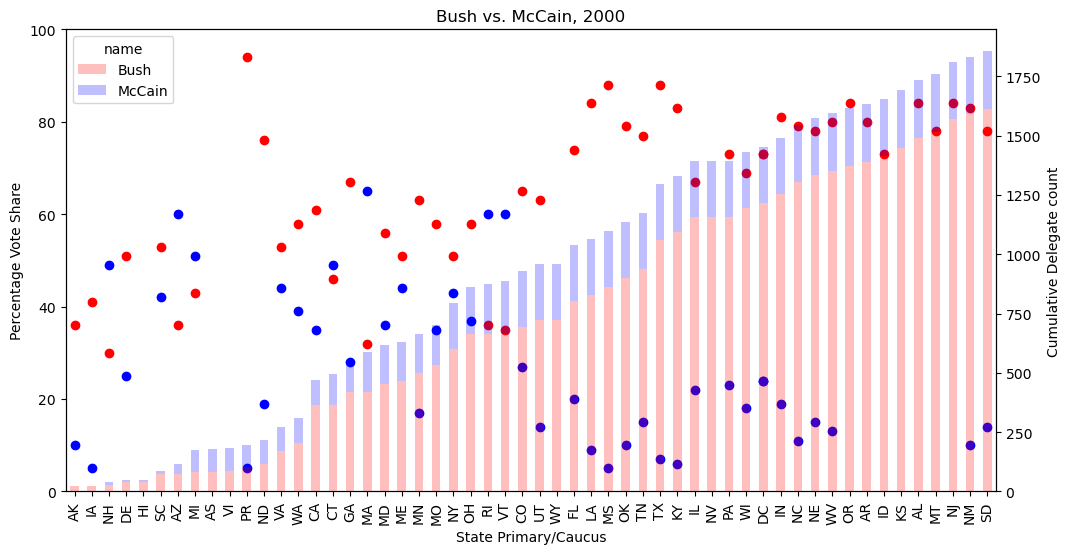

In [2]:
plot(2000, 'R', ['Bush', 'McCain'])

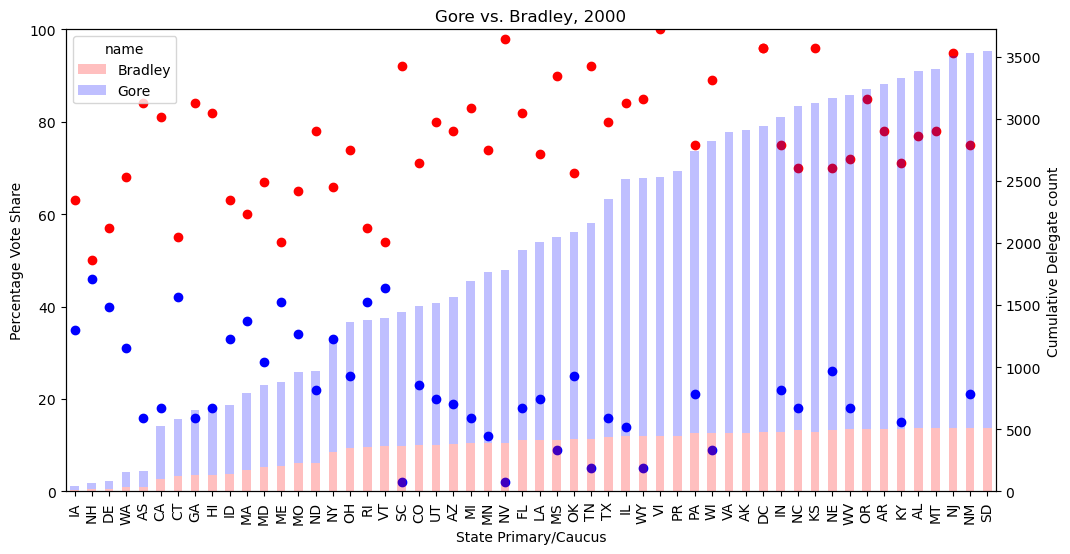

In [3]:
plot(2000, 'D', ['Gore', 'Bradley'])

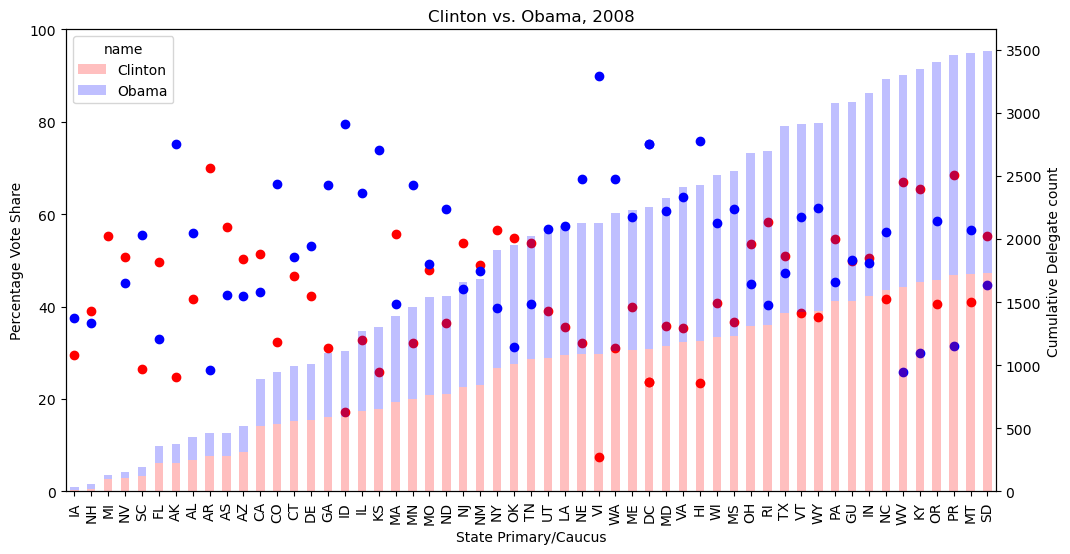

In [4]:
plot(2008, 'D', ['Clinton', 'Obama'])

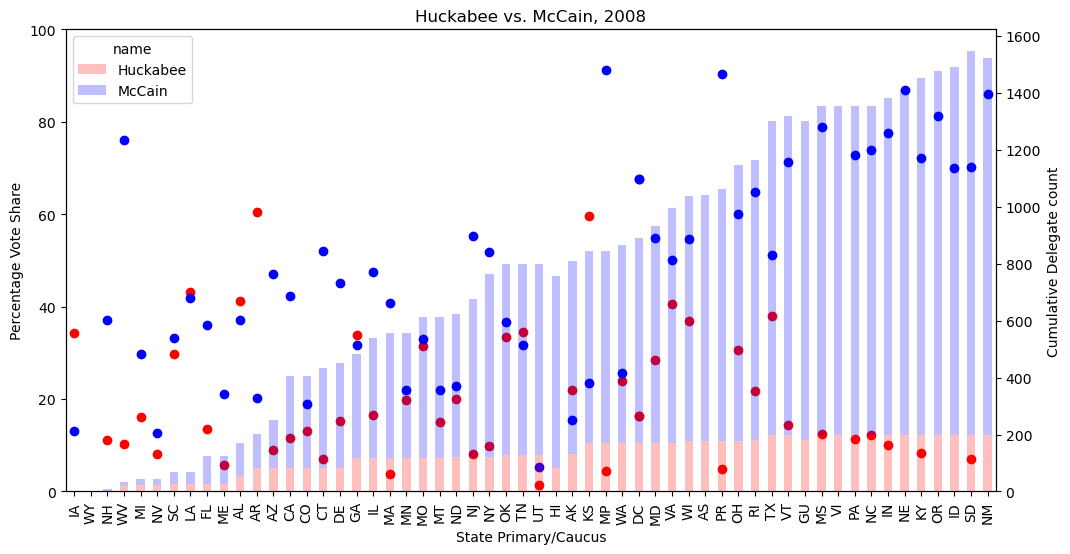

In [5]:
plot(2008, 'R', ['Huckabee', 'McCain'])

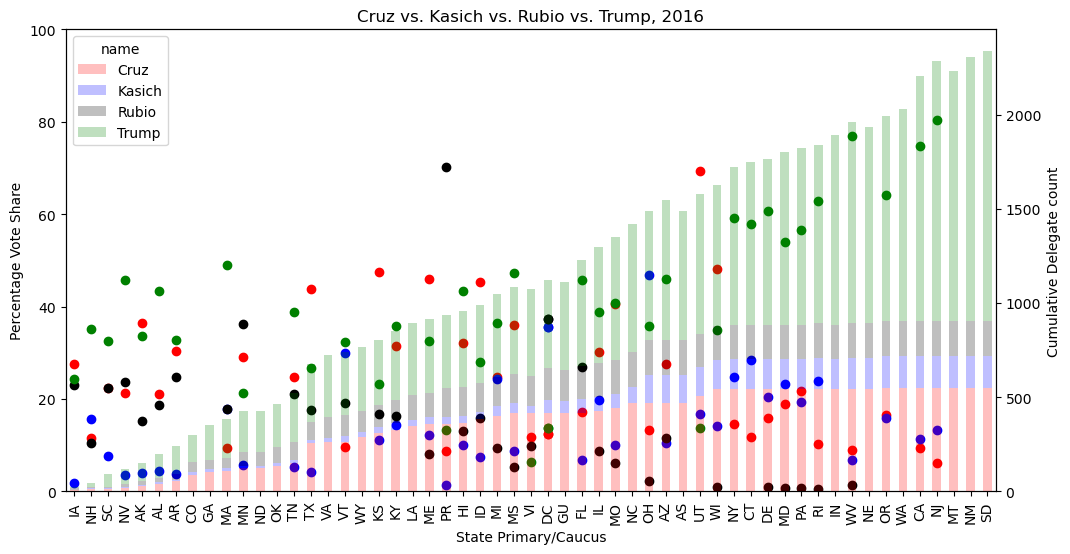

In [6]:
plot(2016, 'R', ['Cruz', 'Kasich', 'Rubio', 'Trump'])

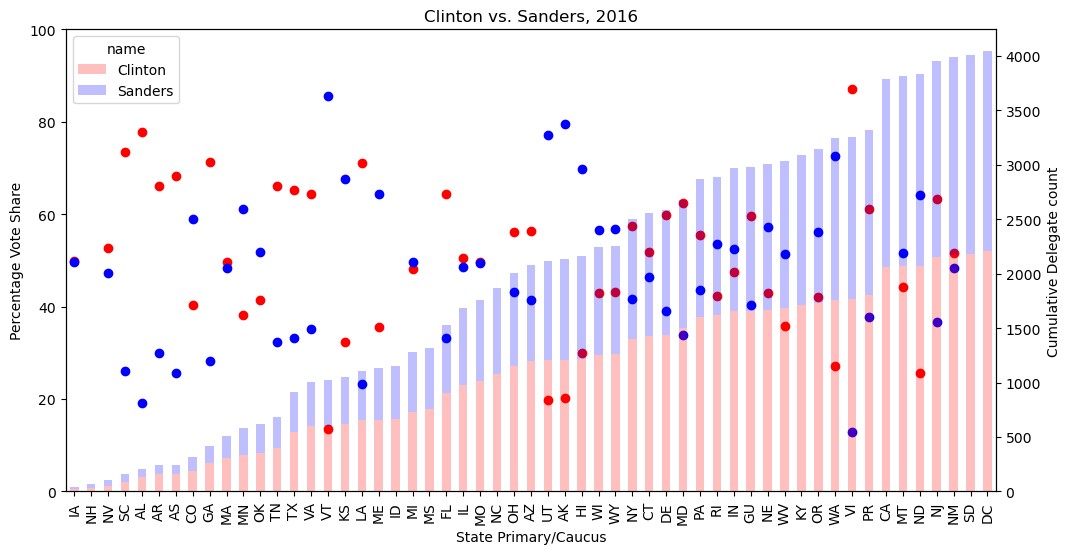

In [7]:
plot(2016, 'D', ['Clinton', 'Sanders'])

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def get_data(year, party):
    
    '''
    Function to load a dataframe of party primaries in a given year.
    States are organised according to voting data and 'cumulative delegates' column is added.
    '''

    # Dictionary of state abbreviations
    states = pd.read_csv(Path().cwd() / 'data' / 'states.csv', delimiter=',')
    states_key = dict(zip(states.State, states.Abbreviation))
    info_file_path = f'./data/{year}/{party}_info.csv'
    df_info = pd.read_csv(info_file_path)
    
    # Load states
    dfs = []
    for s in states_key.values():
        data_file_path = f'./data/{year}/{party}_{s}.csv'
        if os.path.exists(data_file_path):
            # Load data into DataFrame
            state_d = pd.read_csv(data_file_path)
            state_d['state'] = s
            state_d['date'] = df_info.loc[df_info['state'] == s, 'date'].values[0]
            dfs.append(state_d)
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(['date', 'state'], ascending=True, inplace=True)
    df['cumulative_delegates'] = df.groupby('name')['delegates'].cumsum()

    return df


def not_ballot(df, candidates):
    '''
    Function to add in candidates who were not on the ballot in a certain state.
    Candidates are given a cumulative delegate count equal to their cumulative delegates
    in the previous contest where they were on the ballot.
    '''

    dfcs = []
    states_dates = df.sort_values('date').drop_duplicates(subset=['state'])[['state', 'date']]
    for candidate in candidates:
        not_ballot = []
        dfc = df.loc[df['name'] == candidate]
        cumulative_delegates = 0
        for s in states_dates['state']:
            if s not in list(dfc.state):
                not_ballot.append({'name': dfc.name.iloc[0],
                                   'other_name': dfc.other_name.iloc[0],
                                   'state': s,
                                   'date': states_dates.loc[states_dates['state'] == s]['date'].values[0],
                                   'percentage': -99,
                                   'delegates': 0,
                                   'cumulative_delegates': cumulative_delegates})
            else:    
                cumulative_delegates = dfc.loc[dfc['state']==s]['cumulative_delegates'].values[0]

        dfc = pd.concat([dfc, pd.DataFrame(not_ballot)], ignore_index=True)
        
        dfc.sort_values(['date', 'cumulative_delegates'], ascending=[True, True], inplace=True)
        
        dfcs.append(dfc)
        
    return pd.concat(dfcs)


def plot(year, party, candidates, colors=['r', 'b', 'k', 'g']):
    '''
    Plot the vote share and cumulative delegate count for candidates from a given party in a given year.
    '''
    
    df = get_data(year, party)
    
    df = not_ballot(df, candidates)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax2 = ax.twinx()
    for candidate, color in zip(candidates, colors):
        
        ax.scatter(df.loc[df.name == candidate]['state'],
                   df.loc[df.name == candidate]['percentage'],
                   marker='o', linestyle='-', color=color, zorder=2)
        
    pivot_df = df.loc[df.name.isin(candidates)].pivot_table(index='state', columns='name', values='cumulative_delegates', sort=False)
    pivot_df.plot(kind='bar', stacked=True, ax=ax2, zorder=1, color=colors, alpha=.25)
    ax.set_xlabel('State Primary/Caucus')
    ax.set_ylabel('Percentage Vote Share')
    ax2.set_ylabel('Cumulative Delegate count')
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_ylim([0, 100])
    
    ax.set_title(' vs. '.join(candidates) + ', ' + str(year))
    
   
    return fig